# Todo



In [1]:
import numpy as np

import imgaug as ia
from imgaug import augmenters as iaa
from keras.preprocessing.image import img_to_array, load_img, array_to_img

import matplotlib.pyplot as plt
import scipy.io

import cv2
import os

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_PATH = '../../data'
HANDS_DATASET = os.path.join(DATA_PATH, 'original/hand_dataset')
LISA_HAND_DATASET = os.path.join(DATA_PATH, 'original/lisa_hands')
IMAGE_TRAIN_DIR = os.path.join(HANDS_DATASET, 'training_dataset/training_data')
IMAGE_TEST_DIR = os.path.join(HANDS_DATASET, 'test_dataset/test_data')
IMAGE_VAL_DIR = os.path.join(HANDS_DATASET, 'validation_dataset/validation_data')
# TODO: Add testing and validation

NEW_HANDS_ANNOTATED_DATASET = os.path.join(DATA_PATH, 'fabricated/hands_annotated_dataset')
NEW_HANDS_TRAIN = os.path.join(NEW_HANDS_ANNOTATED_DATASET, 'training')
NEW_HANDS_TEST = os.path.join(NEW_HANDS_ANNOTATED_DATASET, 'test')
NEW_HANDS_VAL = os.path.join(NEW_HANDS_ANNOTATED_DATASET, 'validation')
                                  
IMAGES_SUB_DIR = 'images'
ANNOTATIONS_SUB_DIR = 'annotations'
# TODO: Add testing and validation


#### SETTINGS
IMAGE_SHAPE=(225, 225)
MAX_HANDS_TO_DETECT = 10
FLATTENED_DIMENSIONS = MAX_HANDS_TO_DETECT * 4 * 2
CLEAR_EXISTING_IMAGES = True

LIMIT_DATA = 40
#LIMIT_DATA = -1

PERFORM_AUGMENTATION = True

### Load annotations and images

In [3]:
def load_annotations(file):
    f = scipy.io.loadmat(file)
    data = f.get('boxes')
    data = np.array(data)
    
    # We only want the rectangular points from each annotation
    image_annotations = []
    for hand in data[0]:
        # I'm not entirely sure why, but the shape of each file seems to be wrapped in a lot of empty lists
        polygon_points = hand[0][0]
        # We only want the first four items (that actually make up the polygon)
        polygon_points = list(polygon_points)[:4]
        # Again, each point has an empty list wrapped around
        polygon_points = [point[0] for point in polygon_points]
        # points are actually reversed, we want them to be [x, y], but matlab really likes them as [y, x]
        image_annotations.append([[point[1], point[0]] for point in polygon_points])
        

    return image_annotations

In [4]:
def load_annotations_from_dir(directory):
    annotations_dir = os.path.join(directory, 'annotations')
    annotation_files = os.listdir(annotations_dir)
    annotations_for_all_files = []
    i = 0
    for annotation_file in annotation_files:
        if LIMIT_DATA > -1 and i == LIMIT_DATA:
            break
        # ignore config files
        if annotation_file.find('.') == 0:
            continue
        matlab_filepath = os.path.join(annotations_dir, annotation_file)
        annotations = load_annotations(matlab_filepath)
        annotations_for_all_files.append(annotations)
        i += 1
    return annotations_for_all_files

def load_images_from_dir(directory):    
    images_dir = os.path.join(directory, 'images')
    image_filenames = os.listdir(images_dir)

    valid_images = []
    valid_filenames = []

    i = 0
    for _file in image_filenames:
        if LIMIT_DATA > -1 and i == LIMIT_DATA:
            break
        # ignore config files
        if _file.find('.') == 0:
            continue
        filepath = os.path.join(images_dir, _file)
        # img = load_img(filepath, target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        
        img_ORIGINAL = cv2.imread(filepath)
        #imgs.append(img_ORIGINAL)
        valid_images.append(img_to_array(img_ORIGINAL).astype('uint8'))
        valid_filenames.append(_file)
        i += 1

        
    return valid_images, valid_filenames

### Resize Images

In [5]:
# Takes a list of images and their correalted annotations (each image has a matching annotation)
def resize_images_and_annotations(images, annotations):
    if len(images) != len(annotations):
        raise Exception('Length of images {} does not match length of annotations'.format(images, annotations))
        global MAX_HANDS_TO_DETECT, FLATTENED_DIMENSIONS
        
    
    new_images = []
    new_annotations = []
    for (image, annotation) in zip(images, annotations):
        original_height, original_width, original_depth = image.shape
        resized_image = cv2.resize(image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        new_height, new_width, new_depth = resized_image.shape
        
        width_change = new_width / original_width
        height_change = new_height / original_height

        new_annotation = []
        for hand_count in range(MAX_HANDS_TO_DETECT):
            # we have run out of hands, insert a hand with no points
            if len(annotation) <= hand_count:
                new_annotation.append([[0, 0], [0, 0], [0, 0], [0, 0]])
                continue
            hand = annotation[hand_count]

            new_hand = []
            for point in hand:
                x, y = point
                new_x = x * width_change
                new_y = y * height_change
                new_point = [new_x, new_y]
                new_hand.append(new_point)

            new_annotation.append(new_hand)

        new_annotations.append(new_annotation)
        new_images.append(resized_image)
        flattened_annotations = np.reshape(new_annotations, (len(new_annotations), FLATTENED_DIMENSIONS))
    return (new_images, flattened_annotations)

# Load

In [6]:
def load_and_resize_images_and_annotations(directory):
    images_original, original_filenames = load_images_from_dir(directory)
    annotations_original = load_annotations_from_dir(directory)
                
    images, annotations = resize_images_and_annotations(images_original, annotations_original)

    return images, annotations, original_filenames

def turn_annotations_into_keypoints(annotations):
    keypoints_on_images = []
    for hands in annotations:
        keypoints = []
        for hand in hands:
            for point in hand:
                keypoints.append(ia.Keypoint(x=point[0], y=point[1]))
        keypoints_on_images.append(ia.KeypointsOnImage(keypoints, shape=IMAGE_SHAPE))
    return keypoints_on_images

total_number_images_augmented = 0
def augment_images_and_keypoints(images, keypoints_on_images, total_images):
    global total_number_images_augmented
        
    image_width = IMAGE_SHAPE[0]
    image_height = IMAGE_SHAPE[1]
    augmentors = []
    si = 2
    if PERFORM_AUGMENTATION:
        augmentors = [
            iaa.Scale({"height": image_height, "width":image_width})
            
        ]
    seq = iaa.Sequential(augmentors)
    seq_det = seq.to_deterministic() # call this for each batch again, NOT only once at the start
    images_aug = seq_det.augment_images(images)
    keypoints_aug = seq_det.augment_keypoints(keypoints_on_images)
    print(keypoints_on_images[0])
    print(keypoints_aug)
    return images_aug, keypoints_aug

def keypoints_into_annotations(keypoints_on_images):
    annotations = []
    for keypoints in keypoints_on_images:
        image_annotation = []
        for keypoint in keypoints.keypoints:
            image_annotation.append(keypoint.x)
            image_annotation.append(keypoint.y)
        annotations.append(image_annotation)
    return annotations
        
    
# keypoints = turn_annotations_into_keypoints(annotations_original)

# imgs, pts = augment_images_and_keypoints(images_original, keypoints, len(x_train))

# keypoints_into_annotations(keypoints)[0][0:2]

In [7]:
%time train_images, train_annotations, train_original_filenames = load_and_resize_images_and_annotations(IMAGE_TRAIN_DIR)
%time test_images, test_annotations, test_original_filenames = load_and_resize_images_and_annotations(IMAGE_TEST_DIR)
%time val_images, val_annotations, val_original_filenames = load_and_resize_images_and_annotations(IMAGE_VAL_DIR)


CPU times: user 251 ms, sys: 39.3 ms, total: 290 ms
Wall time: 292 ms
CPU times: user 163 ms, sys: 13.3 ms, total: 177 ms
Wall time: 177 ms
CPU times: user 284 ms, sys: 29.9 ms, total: 314 ms
Wall time: 314 ms


## Display

In [8]:
# takes a list of flat annotations and will turn them into actual polygon shapes (around hands)
def hands_from_flat_annotation(annotation):
    annotation = np.array(annotation)
    return annotation.reshape(MAX_HANDS_TO_DETECT, 4, 2).tolist()
    
def hands_from_flat_annotations(annotations):
    return [hands_from_flat_annotation(annotation) for annotation in annotations]

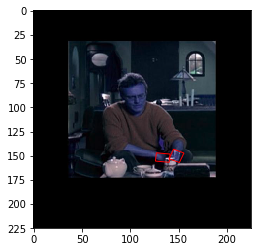

In [9]:
def display_image_with_annotation(img, annotations, ax = plt.gca()):
    plt.imshow(array_to_img(img))
    annotations = hands_from_flat_annotation(annotations)
    for annotation in annotations:
        line = plt.Polygon(annotation, fill=None, edgecolor='r')
        ax.add_patch(line)

first_annotations_from_first_video = train_annotations[0]
first_image = train_images[0]
display_image_with_annotation(first_image, first_annotations_from_first_video)

### Save formatted images

In [10]:
def empty_directory(directory):
    for the_file in os.listdir(directory):
        file_path = os.path.join(directory, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)
def ensure_model_directory_exists(directory):
    try:
        os.makedirs(directory)
    except:
        print('Tried to create "{}" but it already exists'.format(directory))
        if CLEAR_EXISTING_IMAGES:
            print('Emptying directory {}'.format(directory))
            empty_directory(directory)
            

def save_images_and_annotations(images, filenames, annotations, directory):
    image_directory = os.path.join(directory, IMAGES_SUB_DIR)
    annotation_directory = os.path.join(directory, ANNOTATIONS_SUB_DIR)

    ensure_model_directory_exists(image_directory)
    ensure_model_directory_exists(annotation_directory)

    for image, filename, annotation in zip(images, filenames, annotations):
        image_file_path = os.path.join(image_directory, filename)
        annotation_file_path = os.path.join(annotation_directory, filename)
        cv2.imwrite(image_file_path, image)
        np.save(annotation_file_path, annotation)
        
save_images_and_annotations(train_images, train_original_filenames, train_annotations, NEW_HANDS_TRAIN)
save_images_and_annotations(test_images, test_original_filenames, test_annotations, NEW_HANDS_TEST)
save_images_and_annotations(val_images, val_original_filenames, val_annotations, NEW_HANDS_VAL)

Tried to create "../../data/fabricated/hands_annotated_dataset/training/images" but it already exists
Emptying directory ../../data/fabricated/hands_annotated_dataset/training/images
Tried to create "../../data/fabricated/hands_annotated_dataset/training/annotations" but it already exists
Emptying directory ../../data/fabricated/hands_annotated_dataset/training/annotations
Tried to create "../../data/fabricated/hands_annotated_dataset/test/images" but it already exists
Emptying directory ../../data/fabricated/hands_annotated_dataset/test/images
Tried to create "../../data/fabricated/hands_annotated_dataset/test/annotations" but it already exists
Emptying directory ../../data/fabricated/hands_annotated_dataset/test/annotations
Tried to create "../../data/fabricated/hands_annotated_dataset/validation/images" but it already exists
Emptying directory ../../data/fabricated/hands_annotated_dataset/validation/images
Tried to create "../../data/fabricated/hands_annotated_dataset/validation/ann